In [100]:
import pandas as pd
import datetime as dt

In [249]:
def fix_date(x:[str]):
    if " " in str(x):
        if len(str(x.split(" ")[1])) == 1:
            return str(x.split(" ")[0]+"0"+str(x.split(" ")[1]))
        else:
            return str(x.replace(" ",""))
    else:
        return x

In [266]:
def split_column_names_by(this_df, include_dtypes:[list]=["int","float"]):
    # __author__ = "Roman Kaltschew"
    """takes in this_df, splits this_df's columns into two lists of column name by dtype of columns (default ["int","float"]) 
       and returns tuple (incl_lst, excl_lst)"""
    incl_lst = [_ for _ in this_df.select_dtypes(include=include_dtypes).dtypes.index]
    excl_lst = [_ for _ in this_df.select_dtypes(exclude=include_dtypes).dtypes.index]
    return (incl_lst, excl_lst)

### Read all .xlsx files available (aug2018 and feb2016 will be missing (only pdf provided))

In [137]:
data = pd.DataFrame()
for y in range(2015,2022):
    for m in range(1,13):
        if y == 2016 and m == 2:
            continue
        filename = f"./xlsx_files/SB_H01-01-00_{y}m{str(m).zfill(2)}_BE.xlsx"
        try:
            this_month_df = pd.read_excel(filename, sheet_name="Tabelle 3", skiprows=lambda x: x not in range(6, 38))
        except ValueError:
            print("Check:", filename)
        else:    
            print(".", end="")
            this_month_df.rename(columns={'Unnamed: 0': 'day', 'Unnamed: 1': 'weekday', 'Unnamed: 2': 'acc_w_inj', 'Unnamed: 3': 'fatal1',
                           'Unnamed: 4': 'serious1', 'Unnamed: 5': 'light1', 'Unnamed: 6': 'fatal', 'Unnamed: 7': 'serious', 
                           'Unnamed: 8': 'light', 'Unnamed: 9': 'serious_only_prop_damage', 'Unnamed: 10': 'serious_combined'}, 
                              inplace=True)
            this_month_df["YYYYMM"] = int(str(y)+str(m).zfill(2))

            data = pd.concat([data, this_month_df], axis=0)

..........................................Check: ./xlsx_files/SB_H01-01-00_2018m08_BE.xlsx
........................................

In [139]:
data.head(10)

,day,weekday,acc_w_inj,fatal1,serious1,light1,fatal,serious,light,serious_only_prop_damage,serious_combined,YYYYMM,Unnamed: 11,Unnamed: 12
0,1.0,Donnerstag,12.0,–,3,9.0,–,3,12.0,7,19.0,201501,NaN,NaN
1,2.0,Freitag,18.0,–,1,17.0,–,1,21.0,3,21.0,201501,NaN,NaN
2,3.0,Samstag,14.0,–,1,13.0,–,1,16.0,2,16.0,201501,NaN,NaN
3,4.0,Sonntag,18.0,–,4,14.0,–,4,17.0,4,22.0,201501,NaN,NaN
4,5.0,Montag,28.0,–,3,25.0,–,3,29.0,1,29.0,201501,NaN,NaN
5,6.0,Dienstag,26.0,–,4,22.0,–,4,23.0,3,29.0,201501,NaN,NaN
6,7.0,Mittwoch,31.0,–,5,26.0,–,8,34.0,5,36.0,201501,NaN,NaN
7,8.0,Donnerstag,47.0,–,3,44.0,–,3,55.0,8,55.0,201501,NaN,NaN
8,9.0,Freitag,38.0,–,7,31.0,–,9,40.0,8,46.0,201501,NaN,NaN
9,10.0,Samstag,17.0,–,2,15.0,–,2,22.0,1,18.0,201501,NaN,NaN


### Basic cleanup

In [140]:
data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [141]:
data.weekday.value_counts()

Donnerstag    357
Freitag       357
Samstag       357
Sonntag       357
Dienstag      357
Montag        356
Mittwoch      356
Insgesamt       2
Name: weekday, dtype: int64

In [142]:
data = data[data.weekday != "Insgesamt"]

In [144]:
data.weekday.value_counts()

Donnerstag    357
Freitag       357
Samstag       357
Sonntag       357
Dienstag      357
Montag        356
Mittwoch      356
Name: weekday, dtype: int64

In [146]:
data.weekday.isna().value_counts()

False    2497
True       43
Name: weekday, dtype: int64

In [150]:
data = data[data.weekday.isna() == False]

In [285]:
# replace – with 0
for col in data.columns:
    data[col] = list(map(lambda x: 0 if str(x) == "–" else x, data[col]))

In [286]:
# make all relevant columns int
for col in ['acc_w_inj', 'fatal1', 'serious1', 'light1', 'fatal', 'serious', 'light', 
            'serious_only_prop_damage', 'combined_inj_seriousprop']:
    data[col] = data[col].astype(np.int64)

### Create date column

In [160]:
data["day"] = data.day.astype(str)
data["day1"] = list(map(lambda x: x.split(".")[0].zfill(2), data.day))
data["rest"] = list(map(lambda x: str(x)[:4]+"_"+str(x)[4:]+"_", data.YYYYMM))
data["date"] = data.rest + data.day1

C:\Users\roman\AppData\Local\Temp/ipykernel_504/258407988.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["day"] = data.day.astype(str)
C:\Users\roman\AppData\Local\Temp/ipykernel_504/258407988.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["day1"] = list(map(lambda x: x.split(".")[0].zfill(2), data.day))
C:\Users\roman\AppData\Local\Temp/ipykernel_504/258407988.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

In [161]:
data.drop(["day", "day1", "rest"], axis=1, inplace=True)
data = data[['date', 'weekday', 'acc_w_inj', 'fatal1', 'serious1', 'light1', 'fatal', 'serious', 'light',
             'serious_only_prop_damage', 'serious_combined', 'YYYYMM']]

C:\Users\roman\Python\anaconda\envs\DA_Env\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


+ Check for missing dates (should be 2557 days, minus 29 for feb2016 and 31 for oct2018)

In [175]:
len(data) == 2557 - 29 - 31

True

### Add missing months from manually produced csv's from pdf's of these months 

In [181]:
aug18 = pd.read_csv("./manual/201808.csv")
aug18["YYYYMM"] = 201808
feb16 = pd.read_csv("./manual/201602.csv")
feb16["YYYYMM"] = 201602

In [183]:
missing_df = pd.concat([aug18, feb16], axis=0)

+ add date column

In [184]:
missing_df["day"] = missing_df.day.astype(str)
missing_df["day1"] = list(map(lambda x: x.split(".")[0].zfill(2), missing_df.day))
missing_df["rest"] = list(map(lambda x: str(x)[:4]+"_"+str(x)[4:]+"_", missing_df.YYYYMM))
missing_df["date"] = missing_df.rest + missing_df.day1

In [186]:
missing_df.drop(["day", "day1", "rest"], axis=1, inplace=True)
missing_df = missing_df[['date', 'weekday', 'acc_w_inj', 'fatal1', 'serious1', 'light1', 'fatal', 'serious', 'light',
             'serious_only_prop_damage', 'serious_combined', 'YYYYMM']]

+ concat data and missing_df

In [188]:
data = pd.concat([data, missing_df], axis=0)

In [192]:
data = data.sort_values("date")

In [193]:
data.reset_index(drop=True)

,date,weekday,acc_w_inj,fatal1,serious1,light1,fatal,serious,light,serious_only_prop_damage,serious_combined,YYYYMM
0,2015_01_01,Donnerstag,12.0,–,3,9.0,–,3,12.0,7,19.0,201501
1,2015_01_02,Freitag,18.0,–,1,17.0,–,1,21.0,3,21.0,201501
2,2015_01_03,Samstag,14.0,–,1,13.0,–,1,16.0,2,16.0,201501
3,2015_01_04,Sonntag,18.0,–,4,14.0,–,4,17.0,4,22.0,201501
4,2015_01_05,Montag,28.0,–,3,25.0,–,3,29.0,1,29.0,201501
...,...,...,...,...,...,...,...,...,...,...,...,...
2552,2021_12_27,Montag,15.0,–,1,14.0,–,1,19.0,3,18.0,202112
2553,2021_12_28,Dienstag,22.0,–,3,19.0,–,3,24.0,2,24.0,202112
2554,2021_12_29,Mittwoch,26.0,–,6,20.0,–,6,22.0,2,28.0,202112
2555,2021_12_30,Donnerstag,39.0,1,3,35.0,1,3,40.0,2,41.0,202112


In [194]:
data.rename(columns={'serious_combined': 'combined_inj_seriousprop'}, inplace=True)

+ fix broken dates in feb2021

In [240]:
data[data.YYYYMM == 202102].sample(4)

,date,weekday,acc_w_inj,fatal1,serious1,light1,fatal,serious,light,serious_only_prop_damage,combined_inj_seriousprop,YYYYMM
20,2021_02_ 21,Sonntag,18.0,–,3,15.0,–,3,19.0,–,18.0,202102
2,2021_02_ 3,Mittwoch,29.0,–,5,24.0,–,5,31.0,2,31.0,202102
7,2021_02_ 8,Montag,16.0,–,–,16.0,–,–,19.0,5,21.0,202102
21,2021_02_ 22,Montag,35.0,–,5,30.0,–,8,34.0,1,36.0,202102


In [ ]:
base = dt.datetime.date(dt.datetime.strptime("2021_12_31", "%Y_%m_%d"))
date_list = [base - dt.timedelta(days=x) for x in range(2557)]
date_list = [dt.datetime.strftime(d, "%Y_%m_%d") for d in date_list]

In [216]:
dates1 = data.date.to_list()
print(len(date_list), len(dates1))

2557 2557


In [238]:
miss = [_ for _ in dates1 if _ not in date_list]
miss[:4]

['2021_02_ 1', '2021_02_ 10', '2021_02_ 11', '2021_02_ 12']

In [259]:
data[data.YYYYMM == 202102].sample(4)

,date,weekday,acc_w_inj,fatal1,serious1,light1,fatal,serious,light,serious_only_prop_damage,combined_inj_seriousprop,YYYYMM
12,2021_02_13,Samstag,9.0,–,1,8.0,–,1,9.0,–,9.0,202102
16,2021_02_17,Mittwoch,10.0,–,1,9.0,–,1,10.0,2,12.0,202102
9,2021_02_10,Mittwoch,14.0,–,–,14.0,–,–,16.0,6,20.0,202102
11,2021_02_12,Freitag,9.0,–,1,8.0,–,1,8.0,3,12.0,202102


In [253]:
data["date"] = list(map(fix_date, data.date))

In [257]:
data

,date,weekday,acc_w_inj,fatal1,serious1,light1,fatal,serious,light,serious_only_prop_damage,combined_inj_seriousprop,YYYYMM
0,2015_01_01,Donnerstag,12.0,–,3,9.0,–,3,12.0,7,19.0,201501
1,2015_01_02,Freitag,18.0,–,1,17.0,–,1,21.0,3,21.0,201501
2,2015_01_03,Samstag,14.0,–,1,13.0,–,1,16.0,2,16.0,201501
3,2015_01_04,Sonntag,18.0,–,4,14.0,–,4,17.0,4,22.0,201501
4,2015_01_05,Montag,28.0,–,3,25.0,–,3,29.0,1,29.0,201501
...,...,...,...,...,...,...,...,...,...,...,...,...
26,2021_12_27,Montag,15.0,–,1,14.0,–,1,19.0,3,18.0,202112
27,2021_12_28,Dienstag,22.0,–,3,19.0,–,3,24.0,2,24.0,202112
28,2021_12_29,Mittwoch,26.0,–,6,20.0,–,6,22.0,2,28.0,202112
29,2021_12_30,Donnerstag,39.0,1,3,35.0,1,3,40.0,2,41.0,202112


In [260]:
dates1 = data.date.to_list()
miss = [_ for _ in dates1 if _ not in date_list]
miss[:4]

2557 2557


[]

In [269]:
data1 = data.copy()
data1

,date,weekday,acc_w_inj,fatal1,serious1,light1,fatal,serious,light,serious_only_prop_damage,combined_inj_seriousprop,YYYYMM
0,2015_01_01,Donnerstag,12.0,–,3,9.0,–,3,12.0,7,19.0,201501
1,2015_01_02,Freitag,18.0,–,1,17.0,–,1,21.0,3,21.0,201501
2,2015_01_03,Samstag,14.0,–,1,13.0,–,1,16.0,2,16.0,201501
3,2015_01_04,Sonntag,18.0,–,4,14.0,–,4,17.0,4,22.0,201501
4,2015_01_05,Montag,28.0,–,3,25.0,–,3,29.0,1,29.0,201501
...,...,...,...,...,...,...,...,...,...,...,...,...
26,2021_12_27,Montag,15.0,–,1,14.0,–,1,19.0,3,18.0,202112
27,2021_12_28,Dienstag,22.0,–,3,19.0,–,3,24.0,2,24.0,202112
28,2021_12_29,Mittwoch,26.0,–,6,20.0,–,6,22.0,2,28.0,202112
29,2021_12_30,Donnerstag,39.0,1,3,35.0,1,3,40.0,2,41.0,202112


In [290]:
len(data)

2557

In [273]:
for col in data1.columns:
    data1[col] = list(map(lambda x: 0 if str(x) == "–" else x, data[col]))

In [291]:
data.sample(10)

,date,weekday,acc_w_inj,fatal1,serious1,light1,fatal,serious,light,serious_only_prop_damage,combined_inj_seriousprop,YYYYMM
9,2018_07_10,Dienstag,41,0,9,32,0,10,40,1,42,201807
28,2015_09_29,Dienstag,48,0,8,40,0,8,52,1,49,201509
15,2021_09_16,Donnerstag,52,1,6,45,1,7,51,3,55,202109
21,2018_01_22,Montag,26,0,5,21,0,5,26,4,30,201801
0,2020_06_01,Montag,39,0,5,34,0,5,46,3,42,202006
8,2017_05_09,Dienstag,42,0,5,37,0,5,49,6,48,201705
20,2019_12_21,Samstag,23,0,4,19,0,4,29,2,25,201912
12,2019_05_13,Montag,48,0,8,40,0,9,44,4,52,201905
24,2015_12_25,Freitag,7,0,0,7,0,0,14,2,9,201512
28,2017_01_29,Sonntag,15,0,1,14,0,1,16,3,18,201701


### Add columns for bank holiday, school vacation and lockdown (as 1 and 0 for aggregate function)

In [298]:
# dates scraped with vacation_scraper.py
with open("./data/school_vacation_days_berlin.txt") as f:
    school_vac_lst = f.read().splitlines()
with open("./data/bank_holidays_berlin.txt") as f:
    bank_holid_lst = f.read().splitlines()

In [301]:
data["bank_holiday"] = list(map(lambda x: 1 if x in bank_holid_lst else 0, data.date))
data["school_vacation"] = list(map(lambda x: 1 if x in school_vac_lst else 0, data.date))

In [302]:
data

,date,weekday,acc_w_inj,fatal1,serious1,light1,fatal,serious,light,serious_only_prop_damage,combined_inj_seriousprop,YYYYMM,bank_holiday,school_vacation
0,2015_01_01,Donnerstag,12,0,3,9,0,3,12,7,19,201501,1,0
1,2015_01_02,Freitag,18,0,1,17,0,1,21,3,21,201501,0,0
2,2015_01_03,Samstag,14,0,1,13,0,1,16,2,16,201501,0,0
3,2015_01_04,Sonntag,18,0,4,14,0,4,17,4,22,201501,0,0
4,2015_01_05,Montag,28,0,3,25,0,3,29,1,29,201501,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,2021_12_27,Montag,15,0,1,14,0,1,19,3,18,202112,0,1
27,2021_12_28,Dienstag,22,0,3,19,0,3,24,2,24,202112,0,1
28,2021_12_29,Mittwoch,26,0,6,20,0,6,22,2,28,202112,0,1
29,2021_12_30,Donnerstag,39,1,3,35,1,3,40,2,41,202112,0,1


### Add weather data columns


#### Read Data scraped from three weather stations in Berlin

In [312]:
weather_thf = pd.read_csv("./data/weather_data_tempelhof.csv", sep=";")

In [343]:
perci_thf

['0',
 '1,2',
 '0,3',
 '0,8',
 '2,5',
 '0',
 '0,4',
 '9,6',
 '14,9',
 '3',
 '7,2',
 '3,1',
 '3,1',
 '0,3',
 '2,4',
 '4,6',
 '0',
 '0',
 '0',
 '1,9',
 '0,1',
 '0,1',
 '0',
 '0',
 '0',
 '5,3',
 '0,4',
 '5,3',
 '4,5',
 '5',
 '1,7',
 '0,3',
 '0,7',
 '0,8',
 '0,3',
 '0',
 '0',
 '0',
 '1,5',
 '0,3',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '2,5',
 '0',
 '0',
 '0',
 '0,3',
 '0',
 '5,2',
 '4,5',
 '1,7',
 '3',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0,8',
 '0',
 '0',
 '0,3',
 '1,2',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '4,1',
 '0',
 '0',
 '0',
 '0',
 '1,4',
 '4,1',
 '0,8',
 '6,5',
 '5,3',
 '5,2',
 '4,8',
 '3,1',
 '0',
 '0,2',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0,8',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1,1',
 '0,9',
 '2,1',
 '2,6',
 '0',
 '12,3',
 '0',
 '0',
 '6',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0,1',
 '0',
 '0',
 '7,1',
 '0',
 '0',
 '0',
 '0,7',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0,4',


In [369]:
aver_temps_thf = [float(_.replace(",", ".")) for _ in weather_thf.avg_temp.to_list()]
perci_thf = [float(str(_).replace(",", ".")) for _ in weather_thf.percipation_amnt.to_list()]
sunsh_thf = [float(str(_).replace(",", ".")) for _ in weather_thf.sunshine_hrs.to_list()]
# snow_height_thf = weather_thf.snow_height.to_list()   # no snow data provided
set(snow_height_thf)

{'-'}

In [333]:
weather_mrz = pd.read_csv("./data/weather_data_marzahn.csv", sep=";")

In [368]:
aver_temps_mrz = [float(_.replace(",", ".")) for _ in weather_mrz.avg_temp.to_list()]
perci_mrz = [float(str(_).replace("-", "0").replace(",", ".")) for _ in weather_mrz.percipation_amnt.to_list()]
sunsh_mrz = [float(str(_).replace("-", "0").replace(",", ".")) for _ in weather_mrz.sunshine_hrs.to_list()]
snow_height_mrz = [float(str(_).replace("-", "0").replace(",", ".")) for _ in weather_mrz.snow_height.to_list()]


{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 13.0, 15.0}

In [367]:
weather_dlm = pd.read_csv("./data/weather_data_dahlem.csv", sep=";")

In [366]:
aver_temps_dlm = [float(_.replace(",", ".")) for _ in weather_dlm.avg_temp.to_list()]
perci_dlm = [float(str(_).replace("-", "0").replace(",", ".")) for _ in weather_dlm.percipation_amnt.to_list()]
sunsh_dlm = [float(str(_).replace("-", "0").replace(",", ".")) for _ in weather_dlm.sunshine_hrs.to_list()]
snow_height_dlm = [float(str(_).replace("-", "0").replace(",", ".")) for _ in weather_dlm.snow_height.to_list()]


{0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 11.0,
 12.0,
 13.0,
 15.0,
 16.0}

#### Built four columns with averaged data of this weather station df's

In [370]:
aver_temp_three = np.array([aver_temps_thf, aver_temps_mrz, aver_temps_dlm])
perci_three = np.array([perci_thf, perci_mrz, perci_dlm])
sunsh_three = np.array([sunsh_thf, sunsh_mrz, sunsh_dlm])
snow_height_three = np.array([snow_height_mrz, snow_height_dlm])

aver_temp_bln = [round(_, 1) for _ in list(np.average(aver_temp_three, axis=0))]
perci_bln = [round(_, 1) for _ in list(np.average(perci_three, axis=0))]
sunsh_bln = [round(_, 1) for _ in list(np.average(sunsh_three, axis=0))]
snow_height_bln = [round(_, 1) for _ in list(np.average(snow_height_three, axis=0))]

In [371]:
data["aver_temp"] = aver_temp_bln
data["percipation_mm"] = perci_bln
data["sunshine_hours"] = sunsh_bln
data["snow_height_mm"] = snow_height_bln

In [380]:
data.groupby("YYYYMM").sum("mean("temp")

,acc_w_inj,fatal1,serious1,light1,fatal,serious,light,serious_only_prop_damage,combined_inj_seriousprop,bank_holiday,school_vacation,aver_temp,percipation_mm,sunshine_hours,snow_height_mm
YYYYMM,,,,,,,,,,,,,,,
201501,28.000000,0.096774,3.387097,24.516129,0.096774,3.838710,30.193548,3.483871,31.483871,0.032258,0.000000,3.112903,2.464516,0.587097,0.274194
201502,28.642857,0.035714,3.500000,25.107143,0.035714,3.642857,30.678571,3.500000,32.142857,0.000000,0.214286,1.942857,0.257143,2.721429,0.964286
201503,33.580645,0.032258,4.225806,29.322581,0.032258,4.580645,34.806452,3.677419,37.258065,0.000000,0.064516,6.203226,1.461290,2.983871,0.000000
201504,39.533333,0.066667,5.100000,34.366667,0.066667,5.500000,42.866667,2.766667,42.300000,0.066667,0.366667,9.506667,0.783333,4.860000,0.000000
201505,48.161290,0.161290,6.064516,41.935484,0.161290,6.451613,50.419355,3.064516,51.225806,0.096774,0.064516,13.532258,0.551613,4.587097,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202108,45.354839,0.000000,7.032258,38.322581,0.000000,7.387097,45.516129,2.612903,47.967742,0.000000,0.193548,17.780645,2.490323,3.732258,0.000000
202109,48.400000,0.166667,6.566667,41.666667,0.166667,6.966667,49.200000,2.733333,51.133333,0.000000,0.000000,16.003333,1.040000,3.266667,0.000000
202110,40.419355,0.193548,5.580645,34.645161,0.225806,6.129032,39.903226,2.806452,43.225806,0.032258,0.419355,10.870968,0.658065,3.241935,0.000000


In [376]:
# save as csv
# data.to_csv("accident_records_by_day.csv")

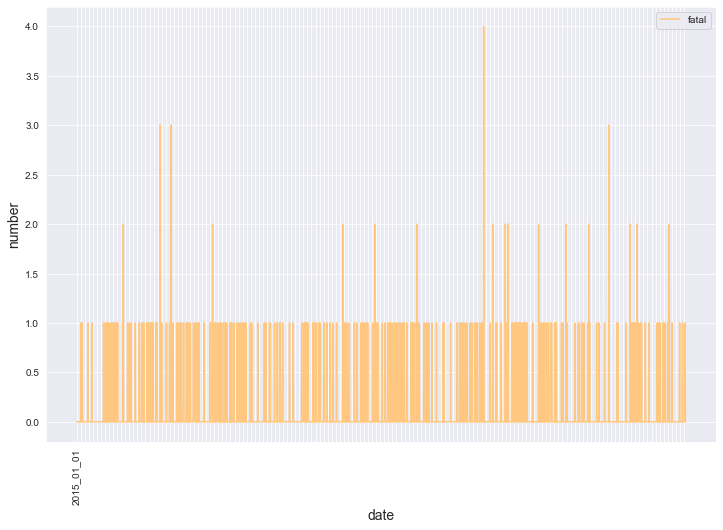

In [ ]:
tester = pd.read_excel("./xlsx_files/SB_H01-01-00_2021m11_BE.xlsx",
                                    sheet_name="Tabelle 3",
                                    skiprows=lambda x: x not in range(6, 39))

tester.rename(columns={'Unnamed: 0': 'day', 'Unnamed: 1': 'weekay', 'Unnamed: 2': 'acc_w_inj', 'Unnamed: 3': 'fatal1',
                       'Unnamed: 4': 'serious1', 'Unnamed: 5': 'light1', 'Unnamed: 6': 'fatal', 'Unnamed: 7': 'serious', 
                       'Unnamed: 8': 'light', 'Unnamed: 9': 'serious_only_prop_damage', 'Unnamed: 10': 'serious_combined'}, 
                          inplace=True)

# tester

tester2 = pd.read_excel("./xlsx_files/SB_H01-01-00_2021m02_BE.xlsx",
                                    sheet_name="Tabelle 3",
                                    skiprows=lambda x: x not in range(6, 39))

tester2.rename(columns={'Unnamed: 0': 'day', 'Unnamed: 1': 'weekay', 'Unnamed: 2': 'acc_w_inj', 'Unnamed: 3': 'fatal1',
                       'Unnamed: 4': 'serious1', 'Unnamed: 5': 'light1', 'Unnamed: 6': 'fatal', 'Unnamed: 7': 'serious', 
                       'Unnamed: 8': 'light', 'Unnamed: 9': 'serious_only_prop_damage', 'Unnamed: 10': 'serious_combined'}, 
                          inplace=True)

#tester2

In [ ]:
data1 = data.copy()


data1["day"] = data1.day.astype(str)
data1["day1"] = list(map(lambda x: x.split(".")[0].zfill(2), data1.day))
data1["rest"] = list(map(lambda x: str(x)[:4]+"_"+str(x)[4:]+"_", data1.YYYYMM))
data1["date"] = data1.rest + data1.day1

data1.drop(["day", "day1", "rest"], axis=1, inplace=True)
